### Fake News Detection 


#import library

In [ ]:
#!pip install nltk

In [ ]:
# download glove and unzip it in Notebook.
#!wget http://nlp.stanford.edu/data/glove.6B.zip
#!unzip glove*.zip

In [ ]:
import pandas as pd 
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('stopwords')
import tensorflow as tf
import numpy as np
import pickle
import random 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
random.seed(0)

**Download Stop words**

In [ ]:
stop = stopwords.words('english')

**Load train csv file**

In [ ]:
df_train = pd.read_csv('train.csv',  on_bad_lines='skip')
df_train.shape

(20800, 5)

**Load test csv file**

In [ ]:
df_test = pd.read_csv('test.csv',on_bad_lines='skip')
df_labels = pd.read_csv('submit.csv', on_bad_lines='skip')

merged_df = pd.merge(df_test[:1000],df_labels[:1000])
merged_df.head()

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",1
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1


In [ ]:
frames = [df_train, merged_df]
df_train = pd.concat(frames)
df_train.shape

(21800, 5)

In [ ]:
df_labels['label']

0       0
1       1
2       0
3       1
4       1
       ..
5195    0
5196    1
5197    0
5198    1
5199    0
Name: label, Length: 5200, dtype: int64

Checking the training dataset label distribution to ensure that,
We have evenly distributed prediction class 

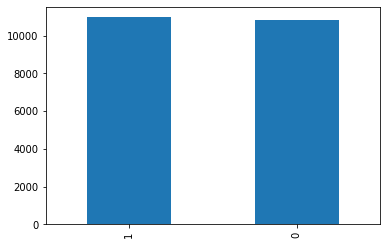

In [ ]:
df_train['label'].value_counts().plot.bar()

In [ ]:
df_author = df_train['author'].value_counts().reset_index()

In [ ]:
df_author[df_author['author']>5]

,index,author
0,Pam Key,257
1,admin,200
2,Jerome Hudson,174
3,Charlie Spiering,149
4,John Hayward,146
...,...,...
652,Frank M. Wanderer PhD,6
653,Michael J. de la Merced,6
654,Edward Wong,6
655,The Anti-Media,6


**Merging title and text data into single dataframe**

In [ ]:
df_train.shape

(21800, 5)

In [ ]:
df_train["text"].isnull().sum()

42

In [ ]:
df_train["title"].notnull().sum()

21219

In [ ]:
df_train = df_train[(df_train["text"].notnull()) & (df_train["title"].notnull())]

In [ ]:
df_train["title_text"]=df_train['author']+ " " + df_train['title']+" "+df_train['text']
### covert to lowercase
df_train["title_text"]=df_train["title_text"].str.lower()
### removing special characters 
df_train["title_text"]=df_train["title_text"].str.replace("n’t"," not")
df_train["title_text"]=df_train["title_text"].str.replace('\W', ' ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
df_train.shape

(21177, 6)

**Removing all stop words from title text**

In [ ]:
df_train['title_text'] =df_train['title_text'].astype(str)
df_train['title_text'] = df_train['title_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

**Check sample data**

In [ ]:
df_train.head()

,id,title,author,text,label,title_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,darrell lucus house dem aide even see comey le...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,daniel j flynn flynn hillary clinton big woman...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,consortiumnews com truth might get fired truth...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,jessica purkiss 15 civilians killed single us ...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,howard portnoy iranian woman jailed fictional ...


**Implement word lemmatizatin on data set**

In [ ]:
#WhitespaceTokenizer and WordNetLemmatizer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [ ]:
#Implement clean sentence feature by removing special characters, stopwords removal  and Lemmatization
def clean_sent(data):
    ### removing special characters 
    data=data.replace("n’t"," not")
    data=data.replace('\W', ' ')

    ### stopwords removal 
    #data =data.astype(str)
    data = data.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

    ### Lemmatization 
    data = data.apply(lemmatize_text)
    data = data.apply(lambda x: ' '.join(x))
    return data
#clean train data set
df_train['title_text'] = clean_sent(df_train['title_text'])

In [ ]:
##preprocessing the data
import re
def data_cleaning(text):
    
    # convert to lowercase
    text = str(text).lower()  
    
    # remove single characters
    text = re.sub(pattern=r'\s+[a-zA-Z]\s+',repl='',string = text) 
    
    # Remove URls, whitespace characters  
    text = re.sub(r'https?://\S+|www\.\S+',repl='',string = text)  
    
    # Removes all the special characters, digits from 0-9 and Capital Letters  
    text = re.sub(r'[^a-z\s]',' ',string = text)
    
    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', string = text)  
    
    return text


df_train['title_text'] = df_train['title_text'].apply(lambda x: data_cleaning(x))

**Merging text and title data**

In [ ]:
X=df_train['title_text'].tolist()
y=df_train['label'].tolist()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=30)#X, df_test.tolist(), y, df_labels['label'].tolist()

**Implement pad sequences on train and text data**

In [ ]:
vocab_size=10000
embedding_dims=16
truc_type="post"
oov_tok='<OOV>'
tokenizer=Tokenizer(oov_token="<OOV>")

tokenizer.fit_on_texts(X_train)
sequence=tokenizer.texts_to_sequences(X_train)

max_length=0
for s in sequence: 
  if max_length<len(s):
    max_length=len(s)

X_train_padded=pad_sequences(sequence, maxlen=max_length, truncating=truc_type)

word_index=tokenizer.word_index
word_index

testing_sequences=tokenizer.texts_to_sequences(X_test)
x_test_padded=pad_sequences(testing_sequences, maxlen=max_length, truncating=truc_type)

In [ ]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

**Check length of test and train data set**

In [ ]:
print("X train padded : " , X_train_padded.shape)
print("x test padded : " ,x_test_padded.shape)
print("y test len : ",len(y_test))
print("y train len : ",len(y_train))

X train padded :  (14823, 11920)
x test padded :  (6354, 11920)
y test len :  6354
y train len :  14823


In [ ]:
# Define path to file containing the embeddings
GLOVE_FILE = './glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE, 'r', errors = 'ignore', encoding='utf8') as f:
    for line in f:
        values = line.split()
        values = ['0' if x=='.' else x for x in values]
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

f.close()

In [ ]:
EMBEDDING_DIM = 100
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
# Initialize empty numpy array with the appropriate size
EMBEDDINGS_MATRIX = np.zeros((vocab_size+1, EMBEDDING_DIM))

# Iterate all of the words in the vocabulary
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector

**Create model and fit dat**

In [ ]:
# when accuracy reaches e.g. ACCURACY_THRESHOLD = 0.95
ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
      if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
        print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
        self.model.stop_training = True

In [ ]:
model=tf.keras.Sequential([
          #tf.keras.layers.Embedding(vocab_size, embedding_dims, input_length=max_length),
          tf.keras.layers.Embedding(vocab_size+1, EMBEDDING_DIM, input_length=max_length, weights=[EMBEDDINGS_MATRIX]),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Bidirectional (tf.keras.layers.LSTM(units=128, return_sequences=True)),
          tf.keras.layers.Dropout(0.4),
          tf.keras.layers.LSTM(units=128),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Dense(1, activation='sigmoid')                       
])
callbacks = myCallback()                                                                                                                                                                    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
training = model.fit(X_train_padded, np.array(y_train), epochs=20, validation_data=(x_test_padded, np.array(y_test)), callbacks=[callbacks])

Epoch 1/20
464/464 [==============================] - 846s 2s/step - loss: 0.3740 - accuracy: 0.8410 - val_loss: 0.3093 - val_accuracy: 0.8727
Epoch 2/20
464/464 [==============================] - 840s 2s/step - loss: 0.2729 - accuracy: 0.8928 - val_loss: 0.2560 - val_accuracy: 0.9142
Epoch 3/20
464/464 [==============================] - 838s 2s/step - loss: 0.1804 - accuracy: 0.9396 - val_loss: 0.2118 - val_accuracy: 0.9249
Epoch 4/20
464/464 [==============================] - 839s 2s/step - loss: 0.1138 - accuracy: 0.9681 - val_loss: 0.3442 - val_accuracy: 0.9067
Epoch 5/20
464/464 [==============================] - 838s 2s/step - loss: 0.0828 - accuracy: 0.9781 - val_loss: 0.2638 - val_accuracy: 0.9303
Epoch 6/20
464/464 [==============================] - 838s 2s/step - loss: 0.0558 - accuracy: 0.9858 - val_loss: 0.3191 - val_accuracy: 0.9276
Epoch 7/20
464/464 [==============================] - 838s 2s/step - loss: 0.0473 - accuracy: 0.9883 - val_loss: 0.2890 - val_accuracy: 0.9267

In [ ]:
def predict_fake_news(score):
    return 1 if score>0.5 else 0
history = model.predict(x_test_padded)
model_predictions = [predict_fake_news(score) for score in history]

**Loss and Accuracy curve**

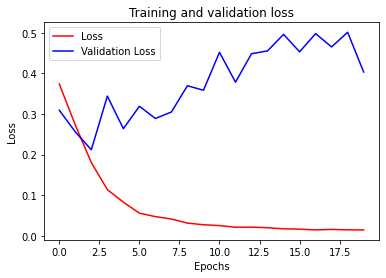

In [ ]:
import matplotlib.pyplot as plt
loss = training.history['loss']
val_loss = training.history['val_loss']

epochs = [*range(20)]

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])
plt.show()

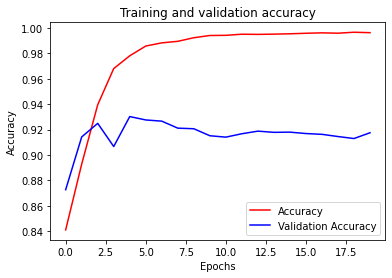

In [ ]:
acc = training.history['accuracy']
val_acc = training.history['val_accuracy']


plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

**Classification report**

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

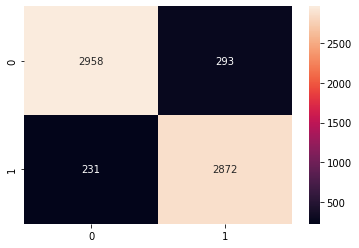

In [ ]:
cf_matrix = confusion_matrix(np.array(y_test), np.array(model_predictions))
sns.heatmap(cf_matrix, annot=True,  fmt="d")

In [ ]:
print(classification_report(list(y_test), model_predictions))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3251
           1       0.91      0.93      0.92      3103

    accuracy                           0.92      6354
   macro avg       0.92      0.92      0.92      6354
weighted avg       0.92      0.92      0.92      6354



**Save model**

In [ ]:
model.save("fake_news.h5")

**Predict model on random data**

In [ ]:
x10=['Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed â€œno debate so far as I could ascertain as to who their spokesman was to beâ€ (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). â€œI am very glad that Miss Adams made it clear that what I am speaking for today is all of us â€”  the 400 of us,â€ Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mortimer Snerds in attendance, the    bespectacled in granny glasses (awarding her matronly wisdom â€”  or at least John Lennon wisdom) took issue with the previous speaker. Despite becoming the first   to win election to a seat in the U. S. Senate since Reconstruction, Edward Brooke came in for criticism for calling for â€œempathyâ€ for the goals of protestors as he criticized tactics. Though Clinton in her senior thesis on Saul Alinsky lamented â€œBlack Power demagoguesâ€ and â€œelitist arrogance and repressive intoleranceâ€ within the New Left, similar words coming out of a Republican necessitated a brief rebuttal. â€œTrust,â€ Rodham ironically observed in 1969, â€œthis is one word that when I asked the class at our rehearsal what it was they wanted me to say for them, everyone came up to me and said â€˜Talk about trust, talk about the lack of trust both for us and the way we feel about others. Talk about the trust bust.â€™ What can you say about it? What can you say about a feeling that permeates a generation and that perhaps is not even understood by those who are distrusted?â€ The â€œtrust bustâ€ certainly busted Clintonâ€™s 2016 plans. She certainly did not even understand that people distrusted her. After Whitewater, Travelgate, the vast   conspiracy, Benghazi, and the missing emails, Clinton found herself the distrusted voice on Friday. There was a load of compromising on the road to the broadening of her political horizons. And distrust from the American people â€”  Trump edged her 48 percent to 38 percent on the question immediately prior to Novemberâ€™s election â€”  stood as a major reason for the closing of those horizons. Clinton described her vanquisher and his supporters as embracing a â€œlie,â€ a â€œcon,â€ â€œalternative facts,â€ and â€œa   assault on truth and reason. â€ She failed to explain why the American people chose his lies over her truth. â€œAs the history majors among you here today know all too well, when people in power invent their own facts and attack those who question them, it can mark the beginning of the end of a free society,â€ she offered. â€œThat is not hyperbole. â€ Like so many people to emerge from the 1960s, Hillary Clinton embarked upon a long, strange trip. From high school Goldwater Girl and Wellesley College Republican president to Democratic politician, Clinton drank in the times and the place that gave her a degree. More significantly, she went from idealist to cynic, as a comparison of her two Wellesley commencement addresses show. Way back when, she lamented that â€œfor too long our leaders have viewed politics as the art of the possible, and the challenge now is to practice politics as the art of making what appears to be impossible possible. â€ Now, as the big woman on campus but the odd woman out of the White House, she wonders how her current station is even possible. â€œWhy arenâ€™t I 50 points ahead?â€ she asked in September. In May she asks why she isnâ€™t president. The woman famously dubbed a â€œcongenital liarâ€ by Bill Safire concludes that lies did her in â€”  theirs, mind you, not hers. Getting stood up on Election Day, like finding yourself the jilted bride on your wedding day, inspires dangerous delusions.']
x40=["In these trying times, Jackie Mason is the Voice of Reason. [In this weekâ€™s exclusive clip for Breitbart News, Jackie discusses the looming threat of North Korea, and explains how President Donald Trump could win the support of the Hollywood left if the U. S. needs to strike first.  â€œIf he decides to bomb them, the whole country will be behind him, because everybody will realize he had no choice and that was the only thing to do,â€ Jackie says. â€œExcept the Hollywood left. Theyâ€™ll get nauseous. â€ â€œ[Trump] could win the left over, theyâ€™ll fall in love with him in a minute. If he bombed them for a better reason,â€ Jackie explains. â€œLike if they have no transgender toilets. â€ Jackie also says itâ€™s no surprise that Hollywood celebrities didnâ€™t support Trumpâ€™s strike on a Syrian airfield this month. â€œThey were infuriated,â€ he says. â€œBecause it might only save lives. That doesnâ€™t mean anything to them. If it only saved the environment, or climate change! Theyâ€™d be the happiest people in the world. â€ Still, Jackie says heâ€™s got nothing against Hollywood celebs. Theyâ€™ve got a tough life in this country. Watch Jackieâ€™s latest clip above.   Follow Daniel Nussbaum on Twitter: @dznussbaum"]
x21=["A Caddo Nation tribal leader has just been freed after spending two days behind bars in North Dakota. Family members say she was simply an innocent bystander in a clash between police and protesters, and was not guilty of anything the police claimed. Via AlternativeNews Jessi Mitchell, of local News 9 reports that â€œfamily members of Caddo Nation chairwoman Tamara Francis-Fourkiller said an anonymous donor paid $2.5 million late Saturday afternoon to release everyone arrested on Thursday at the Dakota Access Pipeline site.â€They added, however, that Francis-Fourkiller was never supposed to have been arrested in the first place. â€œAn expert on sacred burial grounds , Francis-Fourkiller was one of the tribal leaders visiting the Sioux of Standing Rock to advise them during negotiations with the Dakota Access Pipeline construction team,â€ Mitchell continues. â€œRemains were being desecrated in this pipeline, so they had asked a bunch of people to come up there, so thereâ€™s a big conference,â€ Francis-Fourkillerâ€™s sister Loretta Francis explained.On the visit , Francis said her sister and other leaders decided to tour the protest camps. They never thought they would wind up in jail. Francis said her sister had no access to her medication while in custody in Cass County, North Dakota, and now faces charges of conspiracy and rioting. â€œPart of my family was removed on the Trail of Tears and they came here to Oklahoma and they suffered,â€ said Francis. â€œI always feel like each generation â€“ our parents, our grandparents â€“ try to make it better for the next generation and they certainly didnâ€™t want this for my sister.â€Dozens of Native Americans from Oklahoma tribes had gathered Saturday afternoon at the state Capitol, according to Mitchell, with the purpose of voicing their â€œanger at the treatment of the protesters in North Dakota, pointing out this weekâ€™s acquittal of armed protesters at an Oregon wildlife refuge earlier this year.â€â€œWeâ€™re not holding guns. Weâ€™re not armed, and when we see the military right here in the US use that on us, itâ€™s shameful,â€ Comanche Nation tribal council member Sonya Nevaquaya explained.One of the fundamentals of all Native American tribes is the protection of the land. Chanting â€œWater is life!â€ Saturday, the Oklahoma demonstrators hope to rally people from around the country to stand with those in North Dakota and stop construction on the pipeline project. â€œThese pipelines, you hear of a lot of bursts and leaks and it contaminating the waters. What happens when all of our waters and resources are gone?â€ Nevaquaya explained. Francis-Fourkiller says she will be traveling back to her home in Norman as soon as possible."]
x31=["The mystery surrounding The Third Reich and Nazi Germany is still a subject of debate between many observers. Some believe that Nazi Germany, under the control of Adolf Hitler, possessed supernatural powers, and largely employed pseudo-science during the 1933-1945 period. However, some also hold that the above belief is just a mere speculation without any proven fact. Over the years, researchers have searched extensively for answers to some of the more mysterious activities associated with Nazi Germany.Nazi Germany invaded Russia (formerly the USSR) during the Second World War on June 22, 1941. At the time, the German army progressed deep into Russian territory, gaining ground close to the capital Moscow, before the Russians could counter-attack, eventually driving the Nazis back.During the Nazi occupation in Russia, in 1942, the Nazis built a secret military base around the Arctic, code-named â€œSchatzgraberâ€ or â€œTreasure Hunter,â€ which was reportedly very instrumental in the war against Russia. The base was primarily used as a tactical weather station for planning the strategic movements of Nazi troops, warships and submarines. The base also housed eminent Nazi scientists, whom conducted many experiments to help progress a German win of the war. It was widely speculated at the time that the Nazis used the base to contact aliens or extraterrestrial beings. The controversial Ahnenerbe was even linked to the base. The Ahnenerbe was an institute in Nazi Germany. Responsible for researching archaeological and cultural history of the Aryan race, it is rumored to have had heavy occult influences. Founded on July 1, 1935, by Heinrich Himmler, Herman Wirth and Richard Walther DarrÃ©, the Ahnenerbe later conducted experiments and launched expeditions in attempts to prove that mythological Nordic populations had once ruled the world.However, the Nazis abandoned the base in 1944 â€“ a time when the Russian army began its offensive, pushing the Germans out of the country. According to a war-time story, supplies had dwindled to dangerously low levels, and the Nazi officers stationed at the base outpost were forced to kill and eat polar bear, which ultimately, was infected with trichinosis. This caused those stationed at the base to fall severely ill and eventually they required rescue by a German U-boat. Despite Russian authors telling the story of â€œTreasure Hunter,â€ some observers consider it a myth, doubting its existence.But Russian researchers have now announced that â€œTreasure Hunterâ€ has been discovered, saying the base is on the island of Alexandra Land in the Arctic Circle, located 620 miles from the North Pole.A senior researcher at the Russian Arctic National Park, Evgeny Ermolov said in a statement announcing the discovery : â€œBefore it was only known from written sources, but now we also have real proof.â€" ]


In [ ]:
sequence=tokenizer.texts_to_sequences(x31)
# Pad the sequences
token_list = pad_sequences(sequence, maxlen=max_length, truncating=truc_type)
# Get the probabilities of predicting a word
predicted_prob = model.predict(token_list)
# Choose the next word based on the maximum probability
predicted = 1 if predicted_prob[0][0] > .5 else 0
print(predicted)

#fake = 0 
#real = 1


1


In [ ]:
model = tf.keras.models.load_model("fake_news.h5")

In [ ]:
df_test["title_text"]=df_test['title']+" "+df_test['text']+" "+df_test['author']

### covert to lowercase
df_test["title_text"]=df_test["title_text"].str.lower()

### removing special characters 
df_test["title_text"]=df_test["title_text"].str.replace("n’t"," not")
df_test["title_text"]=df_test["title_text"].str.replace('\W', ' ')

### stopwords removal 
df_test['title_text'] =df_test['title_text'].astype(str)
df_test['title_text'] = df_test['title_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

### Lemmatization 
df_test['title_text']=df_test['title_text'].apply(lemmatize_text)
df_test['title_text']=df_test['title_text'].apply(lambda x: ' '.join(x))


df_test['title_text'] = df_test['title_text'].apply(lambda x: data_cleaning(x))
test_sequences=tokenizer.texts_to_sequences(df_test['title_text'])
x_test_padded=pad_sequences(test_sequences, maxlen=max_length, truncating=truc_type)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [ ]:
def predict_fake_news(score):
    return 1 if score>0.5 else 0
history = model.predict(x_test_padded)
model_predictions = [predict_fake_news(score) for score in history]

In [ ]:
print(classification_report(df_labels['label'].tolist(), model_predictions))

              precision    recall  f1-score   support

           0       0.64      0.67      0.66      2339
           1       0.72      0.69      0.71      2861

    accuracy                           0.68      5200
   macro avg       0.68      0.68      0.68      5200
weighted avg       0.68      0.68      0.68      5200



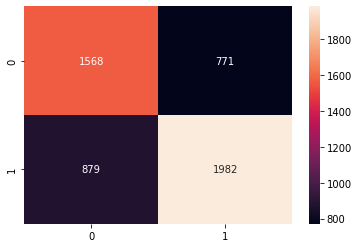

In [ ]:
cf_matrix = confusion_matrix(np.array(df_labels['label']), np.array(model_predictions))
sns.heatmap(cf_matrix, annot=True,  fmt="d")